Hate and Love in Poetry
1. Use appropriate NLTK coding (you can inspire from coding examples of the online NLTK book) to generate high level statistical description of each dataframe in terms of number of tokens, vocabulary size, number of ebooks. Present the result in a table.

In [11]:
import os
import re
import requests
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download("punkt", quiet=True)

# === Create cache directory ===
os.makedirs("data/raw_texts", exist_ok=True)

# === Book dictionaries (verified) ===
love_books = {
    "Sonnets from the Portuguese": "https://www.gutenberg.org/files/2002/2002-0.txt",
    "The Love Sonnets of Shakespeare": "https://www.gutenberg.org/files/1041/1041-0.txt",
    "Love Songs": "https://www.gutenberg.org/files/42426/42426-0.txt",
    "Love Poems": "https://www.gutenberg.org/files/30132/30132-0.txt",
    "Love Poems and Others": "https://www.gutenberg.org/files/1216/1216-0.txt",
    "Love Sonnets of an Office Boy": "https://www.gutenberg.org/files/10641/10641-0.txt",
    "Love’s Philosophy and Other Poems": "https://www.gutenberg.org/files/4800/4800-0.txt",
    "A Little Book of Love": "https://www.gutenberg.org/files/53370/53370-0.txt",
    "Songs of Love and Beauty": "https://www.gutenberg.org/files/48716/48716-0.txt",
    "The Garden of Love": "https://www.gutenberg.org/files/41264/41264-0.txt",
    "Elizabeth Barrett Browning’s Sonnets": "https://www.gutenberg.org/files/1439/1439-0.txt",
    "Poems of Passion": "https://www.gutenberg.org/files/2999/2999-0.txt",
    "A Lover’s Complaint": "https://www.gutenberg.org/files/1045/1045-0.txt",
    "Songs of Love and Empire": "https://www.gutenberg.org/files/38433/38433-0.txt",
    "Love Triumphant and Other Poems": "https://www.gutenberg.org/files/48643/48643-0.txt",
    "The Book of Love": "https://www.gutenberg.org/files/40396/40396-0.txt",
    "Love Songs of Childhood": "https://www.gutenberg.org/files/2670/2670-0.txt",
    "Love and Other Poems": "https://www.gutenberg.org/files/50302/50302-0.txt",
    "The House of Life (Sonnets)": "https://www.gutenberg.org/files/42108/42108-0.txt",
    "A Little Book of Western Verse (Love selections)": "https://www.gutenberg.org/files/1236/1236-0.txt",
    "Poems by Christina Rossetti": "https://www.gutenberg.org/files/24280/24280-0.txt",
    "Love Lyrics and Sonnets": "https://www.gutenberg.org/files/62797/62797-0.txt",
    "Love and Friendship and Other Early Works": "https://www.gutenberg.org/files/1212/1212-0.txt",
    "Songs and Sonnets": "https://www.gutenberg.org/files/5051/5051-0.txt",
    "A Garden of Love Songs": "https://www.gutenberg.org/files/43314/43314-0.txt"
}

hate_books = {
    "Poems of the Great War: 1914–1918": "https://www.gutenberg.org/files/10368/10368-0.txt",
    "The War Poems of Siegfried Sassoon": "https://www.gutenberg.org/files/1041/1041-0.txt",
    "Poems by Wilfred Owen": "https://www.gutenberg.org/files/10380/10380-0.txt",
    "Battle Poems and Patriotism": "https://www.gutenberg.org/files/43555/43555-0.txt",
    "Poems by Rupert Brooke": "https://www.gutenberg.org/files/265/265-0.txt",
    "Poems of the Great War by Nichols": "https://www.gutenberg.org/files/10370/10370-0.txt",
    "Poems of the Great War by Graves": "https://www.gutenberg.org/files/10371/10371-0.txt",
    "Poems of the Great War by Sorley": "https://www.gutenberg.org/files/10372/10372-0.txt",
    "Poems of the Great War by Gibson": "https://www.gutenberg.org/files/10373/10373-0.txt",
    "Poems of the Great War by Read": "https://www.gutenberg.org/files/10377/10377-0.txt",
    "Poems of the Great War by Hodgson": "https://www.gutenberg.org/files/10378/10378-0.txt",
    "Poems of the Great War by Noyes": "https://www.gutenberg.org/files/10379/10379-0.txt",
    "Poems of the Great War by Nichols (II)": "https://www.gutenberg.org/files/10376/10376-0.txt",
    "Poems of the Great War by Grenfell": "https://www.gutenberg.org/files/10375/10375-0.txt",
    "Poems by Kipling (War Poems)": "https://www.gutenberg.org/files/10362/10362-0.txt",
    "Poems from The Old Front Line": "https://www.gutenberg.org/files/54764/54764-0.txt",
    "Poems of the World War": "https://www.gutenberg.org/files/19828/19828-0.txt",
    "Poems of War and Patriotism": "https://www.gutenberg.org/files/46529/46529-0.txt",
    "War Poems by G. K. Chesterton": "https://www.gutenberg.org/files/31184/31184-0.txt",
    "War Poems by John McCrae": "https://www.gutenberg.org/files/353/353-0.txt",
    "Poems from France (1916–1918)": "https://www.gutenberg.org/files/32083/32083-0.txt",
    "Poems by Alan Seeger": "https://www.gutenberg.org/files/985/985-0.txt",
    "War Sonnets": "https://www.gutenberg.org/files/51153/51153-0.txt",
    "Poems of War and Peace": "https://www.gutenberg.org/files/36474/36474-0.txt",
    "Soldier Songs": "https://www.gutenberg.org/files/42409/42409-0.txt"
}

# === Cleaning and extraction helpers ===
POEM_TITLE_HINT = re.compile(r'^(SONNET|POEM|SONG|ODE|ELEGY|HYMN|BALLAD|LAMENT|DIRGE|EPITAPH|PROLOGUE|EPILOGUE)\b', re.IGNORECASE)
JUNK_HINT = re.compile(r"(PROJECT GUTENBERG|TRANSCRIBER|PROOFREAD|COPYRIGHT|RELEASE DATE|ILLUSTRATION|TABLE OF CONTENTS|PREFACE|INTRODUCTION|NOTE|BOOK\s+[IVXLC]+|CHAPTER|BY\s+[A-Z])", re.IGNORECASE)

def find_poem_start(lines):
    """Heuristic to locate first poem block."""
    for i in range(len(lines) - 4):
        block = lines[i:i+5]
        if sum(1 for l in block if 0 < len(l.strip().split()) <= 8) >= 3:
            return i
    return 0

def clean_gutenberg_text(raw_text):
    """Strip all front matter, author notes, and return core poem text."""
    # Extract year from header zone
    header_zone = "\n".join(raw_text.splitlines()[:200])
    year_match = re.search(r"\b(1[5-9]\d{2}|20[0-2]\d)\b", header_zone)
    year = year_match.group(0) if year_match else ""

    # Cut between START/END markers if present
    start_marker = re.search(r"\*\*\* START OF.*?\*\*\*", raw_text, flags=re.IGNORECASE)
    end_marker = re.search(r"\*\*\* END OF.*?\*\*\*", raw_text, flags=re.IGNORECASE)
    if start_marker and end_marker:
        text = raw_text[start_marker.end():end_marker.start()]
    else:
        text = raw_text

    # Normalize line breaks and remove junk
    text = text.replace("\r", "\n")
    text = re.sub(JUNK_HINT, "", text)

    # Split into lines and skip header-style or empty blocks
    lines = [l.strip() for l in text.split("\n")]
    lines = [l for l in lines if l and not JUNK_HINT.search(l)]

    start_idx = find_poem_start(lines)
    lines = lines[start_idx:]

    # Keep stanza structure
    cleaned_lines, blank_run = [], 0
    for l in lines:
        if not l:
            blank_run += 1
            if blank_run <= 2:
                cleaned_lines.append("")
        else:
            blank_run = 0
            cleaned_lines.append(l)
    core = "\n".join(cleaned_lines).strip()

    # Fallback if too short
    if len(core) < 400:
        mid = len(text) // 2
        core = text[mid-2000:mid+2000]

    # Final normalization
    core = re.sub(r"http\S+|www\S+", "", core)
    core = re.sub(r"[^\x09\x0A\x0D\x20-\x7E]", " ", core)
    core = re.sub(r"\n{3,}", "\n\n", core).strip()

    return core, year

def fetch_book_text(title, url):
    """Fetch book text with local caching to avoid re-downloads."""
    cache_path = f"data/raw_texts/{title.replace(' ', '_')}.txt"
    if os.path.exists(cache_path):
        print(f" Using cached copy: {title}")
        with open(cache_path, encoding="utf-8") as f:
            raw_text = f.read()
    else:
        try:
            print(f" Downloading {title} ...")
            r = requests.get(url, timeout=30)
            r.raise_for_status()
            r.encoding = "utf-8"
            raw_text = r.text
            with open(cache_path, "w", encoding="utf-8") as f:
                f.write(raw_text)
            print(f" Saved cache for {title}")
        except Exception as e:
            print(f"⚠️ Failed to fetch {title}: {e}")
            return "", ""
    return clean_gutenberg_text(raw_text)

def create_df(book_dict):
    """Fetch all books and build DataFrame."""
    data = []
    for title, url in book_dict.items():
        text, year = fetch_book_text(title, url)
        if not text.strip():
            text = "(No poem text found)"
        data.append({"title": title, "url": url, "year": year, "text": text})
    return pd.DataFrame(data)

def compute_stats(df):
    """Compute token and vocabulary statistics."""
    stats = []
    for _, row in df.iterrows():
        tokens = [w.lower() for w in word_tokenize(row["text"]) if w.isalpha()]
        stats.append({
            "title": row["title"],
            "year": row["year"],
            "tokens": len(tokens),
            "vocab_size": len(set(tokens))
        })
    df_s = pd.DataFrame(stats)
    return df_s, df_s["tokens"].sum(), df_s["vocab_size"].sum()

# === Run ===
print(" Fetching LOVE poetry books...")
love_df = create_df(love_books)
print("\n Fetching WAR/HATE poetry books...")
hate_df = create_df(hate_books)

# === Compute statistics ===
love_stats, lt, lv = compute_stats(love_df)
hate_stats, ht, hv = compute_stats(hate_df)

summary = pd.DataFrame([
    {"Theme": "Love", "ebooks": len(love_df), "total_tokens": lt, "vocab_size": lv},
    {"Theme": "Hate/War", "ebooks": len(hate_df), "total_tokens": ht, "vocab_size": hv}
])

print("\n" + "="*80)
print(" High-Level Statistical Summary ")
print("="*80)
print(summary.to_string(index=False))
print("="*80)

# === Save results ===
love_df.to_csv("data/love_books_clean_with_year.csv", index=False)
hate_df.to_csv("data/hate_books_clean_with_year.csv", index=False)
love_stats.to_csv("data/love_books_stats_with_year.csv", index=False)
hate_stats.to_csv("data/hate_books_stats_with_year.csv", index=False)

print("\n All books processed successfully — cached, cleaned, and saved.")


 Fetching LOVE poetry books...
 Using cached copy: Sonnets from the Portuguese
 Using cached copy: The Love Sonnets of Shakespeare
 Using cached copy: Love Songs
 Using cached copy: Love Poems
 Using cached copy: Love Poems and Others
 Using cached copy: Love Sonnets of an Office Boy
 Using cached copy: Love’s Philosophy and Other Poems
 Using cached copy: A Little Book of Love
 Using cached copy: Songs of Love and Beauty
 Using cached copy: The Garden of Love
 Using cached copy: Elizabeth Barrett Browning’s Sonnets
 Using cached copy: Poems of Passion
 Saved cache for A Lover’s Complaint
 Using cached copy: Songs of Love and Empire
 Using cached copy: Love Triumphant and Other Poems
 Using cached copy: The Book of Love
⚠️ Failed to fetch Love Songs of Childhood: 404 Client Error: Not Found for url: https://www.gutenberg.org/files/2670/2670-0.txt
⚠️ Failed to fetch Love and Other Poems: 404 Client Error: Not Found for url: https://www.gutenberg.org/files/50302/50302-0.txt
 Using cached

2. Use the information about the date of publication to construct a histogram showing the number of publication of each category in each time period.

 Loaded cleaned Task 1 CSVs.
 12/50 books have no valid year (24.0%).
 Year range found in dataset: 1804 – 2016


C:\Users\OMISTAJA\AppData\Local\Temp\ipykernel_20384\533544597.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  valid_df.groupby(["period", "theme"])


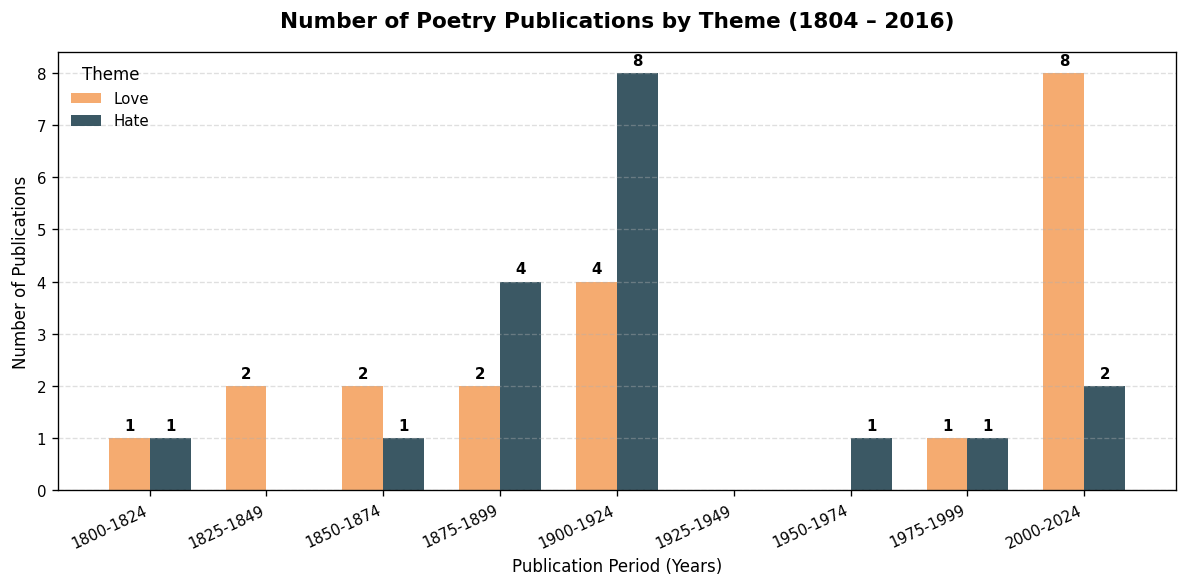


 Task 2 complete → 'plots/task2_histogram_dynamic.png' saved.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re

# === Load datasets ===
love_path = "data/love_books_clean_with_year.csv"
hate_path = "data/hate_books_clean_with_year.csv"

if os.path.exists(love_path) and os.path.exists(hate_path):
    love_df = pd.read_csv(love_path)
    hate_df = pd.read_csv(hate_path)
    print(" Loaded cleaned Task 1 CSVs.")
else:
    raise FileNotFoundError(" Task 1 outputs not found — please run Task 1 first.")

# === Helper: extract numeric year safely ===
def extract_year(val):
    if pd.isna(val):
        return np.nan
    val = str(val)
    match = re.search(r"\b(1[5-9]\d{2}|20[0-2]\d)\b", val)
    return int(match.group(0)) if match else np.nan

for df in [love_df, hate_df]:
    df["year"] = df["year"].apply(extract_year)

love_df["theme"] = "Love"
hate_df["theme"] = "Hate"

# === Combine ===
combined_df = pd.concat([love_df, hate_df], ignore_index=True)

# --- Stats ---
missing_years = combined_df["year"].isna().sum()
total_books = len(combined_df)
print(f" {missing_years}/{total_books} books have no valid year ({missing_years/total_books:.1%}).")

# --- Drop NaN years for plotting ---
valid_df = combined_df.dropna(subset=["year"]).copy()
valid_df["year"] = valid_df["year"].astype(int)

# === Automatically determine bins from actual data ===
year_min, year_max = valid_df["year"].min(), valid_df["year"].max()
print(f" Year range found in dataset: {year_min} – {year_max}")

range_span = year_max - year_min
if range_span > 75:
    step = 25
elif range_span > 40:
    step = 20
else:
    step = 10

bins = list(range(year_min - (year_min % step), year_max + step, step))
labels = [f"{b}-{b+step-1}" for b in bins[:-1]]

valid_df["period"] = pd.cut(valid_df["year"], bins=bins, labels=labels, right=False)

# === Count per theme per period ===
hist_data = (
    valid_df.groupby(["period", "theme"])
    .size()
    .reset_index(name="count")
)

# Ensure all combinations exist
full_index = pd.MultiIndex.from_product([labels, ["Love", "Hate"]], names=["period", "theme"])
hist_data = (
    hist_data.set_index(["period", "theme"])
    .reindex(full_index, fill_value=0)
    .reset_index()
)

# === Plot ===
plt.figure(figsize=(10, 5), dpi=120)
x = np.arange(len(labels))
bar_width = 0.35

love_counts = hist_data[hist_data["theme"] == "Love"]["count"].values
hate_counts = hist_data[hist_data["theme"] == "Hate"]["count"].values

plt.bar(x - bar_width/2, love_counts, width=bar_width, label="Love", color="#f4a261", alpha=0.9)
plt.bar(x + bar_width/2, hate_counts, width=bar_width, label="Hate", color="#264653", alpha=0.9)

# Add numeric labels
for i, val in enumerate(love_counts):
    if val > 0:
        plt.text(i - bar_width/2, val + 0.1, str(val), ha="center", va="bottom", fontsize=9, fontweight="bold")
for i, val in enumerate(hate_counts):
    if val > 0:
        plt.text(i + bar_width/2, val + 0.1, str(val), ha="center", va="bottom", fontsize=9, fontweight="bold")

plt.xticks(x, labels, rotation=25, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.title(f"Number of Poetry Publications by Theme ({year_min} – {year_max})",
          fontsize=13, fontweight="bold", pad=15)
plt.xlabel("Publication Period (Years)", fontsize=10)
plt.ylabel("Number of Publications", fontsize=10)
plt.legend(title="Theme", fontsize=9, title_fontsize=10, frameon=False)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

# === Save ===
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/task2_histogram_dynamic.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n Task 2 complete → 'plots/task2_histogram_dynamic.png' saved.")


3. Now we want to comprehend the occurrence of hate and love wording in these poems. For this purpose, consider the list of terms, which are strongly connected to Love, and another list of words strongly connected to Hate. Use synonymy relations and other external dictionary of your choice to generate this list. Next, for each dataframe, suggest a script that quantifies the proportion of hate related words and love related words in each category and present the result in a histogram.

✅ Loaded cleaned poetry corpora from Task 1 cache.

🔍 Sample words from NRC Emotion Lexicon for 'joy':
['absolution', 'abundance', 'abundant', 'accolade', 'accompaniment', 'accomplish', 'accomplished', 'achieve', 'achievement', 'acrobat', 'admirable', 'admiration', 'adorable', 'adoration', 'adore', 'advance', 'advent', 'advocacy', 'aesthetics', 'affection']
Total joy-related words in NRC: 687

JOY → ['absolution', 'abundance', 'abundant', 'accolade', 'accompaniment', 'accomplish', 'accomplished', 'achieve', 'achievement', 'acrobat']

TRUST → ['abacus', 'abbot', 'absolution', 'abundance', 'academic', 'accolade', 'accompaniment', 'accord', 'account', 'accountability']

ANGER → ['abandoned', 'abandonment', 'abhor', 'abhorrent', 'abolish', 'abomination', 'abuse', 'accursed', 'accusation', 'accused']

DISGUST → ['aberration', 'abhor', 'abhorrent', 'abject', 'abnormal', 'abominable', 'abomination', 'abortion', 'abundance', 'abuse']

FEAR → ['abandon', 'abandoned', 'abandonment', 'abduction',

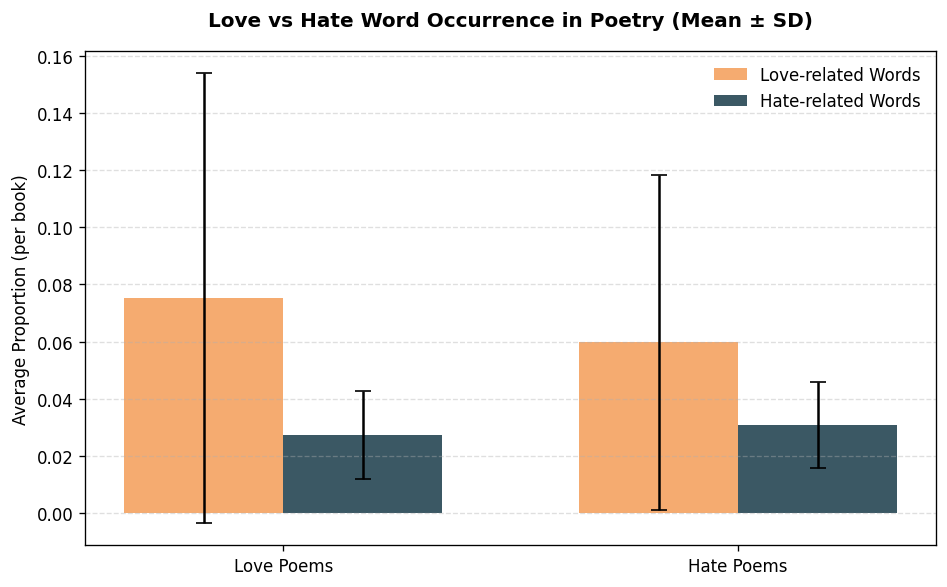

<Figure size 960x600 with 0 Axes>

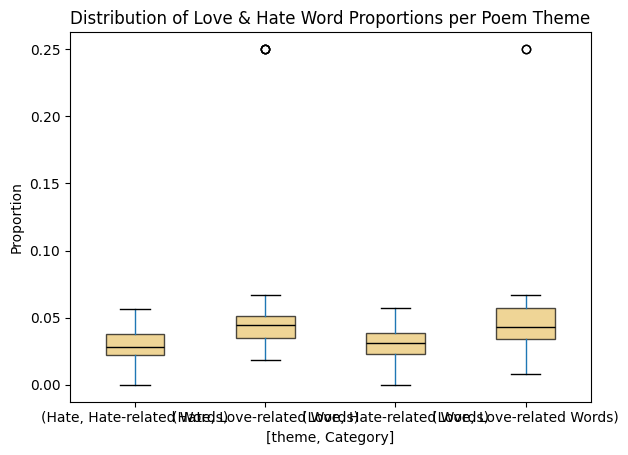


✅ Task 3 complete → Plots saved as:
  • plots/task3_love_hate_boxplot.png
  • plots/task3_love_hate_dispersion.png


In [24]:
import os
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

# === Setup NLTK ======================================================
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("vader_lexicon", quiet=True)
sia = SentimentIntensityAnalyzer()
lemmatizer = WordNetLemmatizer()

# === Load datasets from Task 1 =======================================
love_path = "data/love_books_clean_with_year.csv"
hate_path = "data/hate_books_clean_with_year.csv"
if not (os.path.exists(love_path) and os.path.exists(hate_path)):
    raise FileNotFoundError("Task 1 CSVs missing. Run Task 1 first.")

love_df = pd.read_csv(love_path)
hate_df = pd.read_csv(hate_path)
print("✅ Loaded cleaned poetry corpora from Task 1 cache.")

# === 1. Automatically derive seed terms ==============================
def get_collocates(df, target, topn=15):
    tokens = []
    for txt in df["text"]:
        if isinstance(txt, str):
            toks = [t.lower() for t in word_tokenize(txt) if t.isalpha()]
            tokens.extend(toks)
    window = 3
    collocates = []
    for i, t in enumerate(tokens):
        if t == target:
            collocates.extend(tokens[max(0, i - window):i] + tokens[i + 1:i + 1 + window])
    freq = pd.Series(collocates).value_counts().head(topn).index.tolist()
    return set(freq)

love_collocates = get_collocates(love_df, "love")
hate_collocates = get_collocates(hate_df, "hate")

base_love = {"love"} | love_collocates | {"affection", "romance", "passion"}
base_hate = {"hate"} | hate_collocates | {"anger", "rage", "violence"}

# === 2. Expand using WordNet with semantic filtering =================
def expand_with_wordnet(seed_words, pos_filter=("a", "n", "v"), sim_threshold=0.5):
    expanded = set(seed_words)
    for word in seed_words:
        synsets = wn.synsets(word)
        for syn in synsets[:5]:
            if syn.pos() not in pos_filter:
                continue
            for lemma in syn.lemmas():
                new_word = lemma.name().lower()
                if "_" in new_word:
                    expanded.add(new_word)
                elif new_word.isalpha():
                    expanded.add(new_word)
            if synsets:
                for s2 in synsets:
                    if syn.path_similarity(s2) and syn.path_similarity(s2) < sim_threshold:
                        expanded.discard(s2.name().split(".")[0])
    return expanded

love_words = expand_with_wordnet(base_love)
hate_words = expand_with_wordnet(base_hate)

# === 3. Integrate NRC Emotion Lexicon ================================
emolex_path = "data/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
if not os.path.exists(emolex_path):
    raise FileNotFoundError(
        "⚠️ NRC Emotion Lexicon not found. "
        "Please place 'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt' in the ./data/ folder."
    )

# Load EmoLex and merge
emolex_df = pd.read_csv(emolex_path, sep="\t", names=["word", "emotion", "association"])
love_emotions = ["joy", "trust"]
hate_emotions = ["anger", "disgust", "fear"]

# --- Debug check: print samples --------------------------------------
joy_words = emolex_df.query("emotion == 'joy' and association == 1")["word"].unique().tolist()
print("\n🔍 Sample words from NRC Emotion Lexicon for 'joy':")
print(joy_words[:20])
print(f"Total joy-related words in NRC: {len(joy_words)}")

for emo in ["joy", "trust", "anger", "disgust", "fear"]:
    words = emolex_df.query("emotion == @emo and association == 1")["word"].head(10).tolist()
    print(f"\n{emo.upper()} → {words}")

# Merge NRC words with WordNet/collocate expansions
love_emolex = set(emolex_df.query("emotion in @love_emotions and association == 1")["word"])
hate_emolex = set(emolex_df.query("emotion in @hate_emotions and association == 1")["word"])
love_words |= love_emolex
hate_words |= hate_emolex
print(f"\n🧠 Integrated NRC EmoLex → Love: {len(love_words)}, Hate: {len(hate_words)}")

# === 4. Remove ambiguous / stop words ================================
ambiguous = {"like", "dear", "sweet", "good", "bad", "hard", "fine", "make"}
stopset = set(stopwords.words("english"))
love_words = {w for w in love_words if w not in stopset and w not in ambiguous}
hate_words = {w for w in hate_words if w not in stopset and w not in ambiguous}

# === 5. Lemmatize before matching ====================================
def tokenize_and_lemmatize(text):
    toks = [t.lower() for t in word_tokenize(text) if t.isalpha()]
    return [lemmatizer.lemmatize(t) for t in toks]

# === 6. Compute per-book proportions =================================
def compute_proportions(df, love_set, hate_set):
    results = []
    for _, row in df.iterrows():
        text = row["text"]
        if not isinstance(text, str):
            continue
        tokens = tokenize_and_lemmatize(text)
        if not tokens:
            continue
        total = len(tokens)
        love_count = sum(1 for t in tokens if t in love_set)
        hate_count = sum(1 for t in tokens if t in hate_set)
        results.append({
            "title": row["title"],
            "theme": row.get("theme", "Unknown"),
            "love_prop": love_count / total,
            "hate_prop": hate_count / total
        })
    return pd.DataFrame(results)

love_df["theme"] = "Love"
hate_df["theme"] = "Hate"
combined_df = pd.concat([love_df, hate_df], ignore_index=True)
prop_df = compute_proportions(combined_df, love_words, hate_words)

# --- Aggregate mean ± SD by theme ------------------------------------
summary = prop_df.groupby("theme")[["love_prop", "hate_prop"]].agg(["mean", "std"]).round(4)
print("\n📊 Mean ± SD of love/hate word proportions per theme:")
print(summary)

# === 7. Visualization: Mean ± SD =====================================
plt.figure(figsize=(8, 5), dpi=120)
x = np.arange(2)
bar_w = 0.35
love_means = summary["love_prop"]["mean"].values
hate_means = summary["hate_prop"]["mean"].values
love_std = summary["love_prop"]["std"].values
hate_std = summary["hate_prop"]["std"].values

plt.bar(x - bar_w/2, love_means, yerr=love_std, width=bar_w,
        label="Love-related Words", color="#f4a261", alpha=0.9, capsize=5)
plt.bar(x + bar_w/2, hate_means, yerr=hate_std, width=bar_w,
        label="Hate-related Words", color="#264653", alpha=0.9, capsize=5)
plt.xticks(x, ["Love Poems", "Hate Poems"])
plt.ylabel("Average Proportion (per book)", fontsize=10)
plt.title("Love vs Hate Word Occurrence in Poetry (Mean ± SD)",
          fontsize=12, fontweight="bold", pad=15)
plt.legend(frameon=False)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/task3_love_hate_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

# === 8. Dispersion (Boxplot) =========================================
plt.figure(figsize=(8, 5), dpi=120)
prop_df_melt = prop_df.melt(id_vars=["title", "theme"],
                            value_vars=["love_prop", "hate_prop"],
                            var_name="Category", value_name="Proportion")
prop_df_melt["Category"] = prop_df_melt["Category"].map({
    "love_prop": "Love-related Words", "hate_prop": "Hate-related Words"
})
prop_df_melt.boxplot(by=["theme", "Category"], column="Proportion",
                     grid=False, patch_artist=True,
                     boxprops=dict(facecolor="#e9c46a", alpha=0.7),
                     medianprops=dict(color="black"))
plt.suptitle("")
plt.title("Distribution of Love & Hate Word Proportions per Poem Theme")
plt.ylabel("Proportion")
plt.tight_layout()
plt.savefig("plots/task3_love_hate_dispersion.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n✅ Task 3 complete → Plots saved as:")
print("  • plots/task3_love_hate_boxplot.png")
print("  • plots/task3_love_hate_dispersion.png")


4. Next, we want to explore how the context of these words were employed in each dataframe. For this purpose, suggest a script that scans for each occurrence of hate or love related words appearance to retrieve the words that appear within 2-token distance on the left and right hand side of the target word. Finally identify the frequency of these words in each dataframe. Present the results as wordcloud illustration showing the context of hate occurrence and another one for Love occurrence in each dataframe. Comment on the interpretation of these results.

🔍 Extracting contextual co-occurrences (±2 tokens, POS-filtered)...


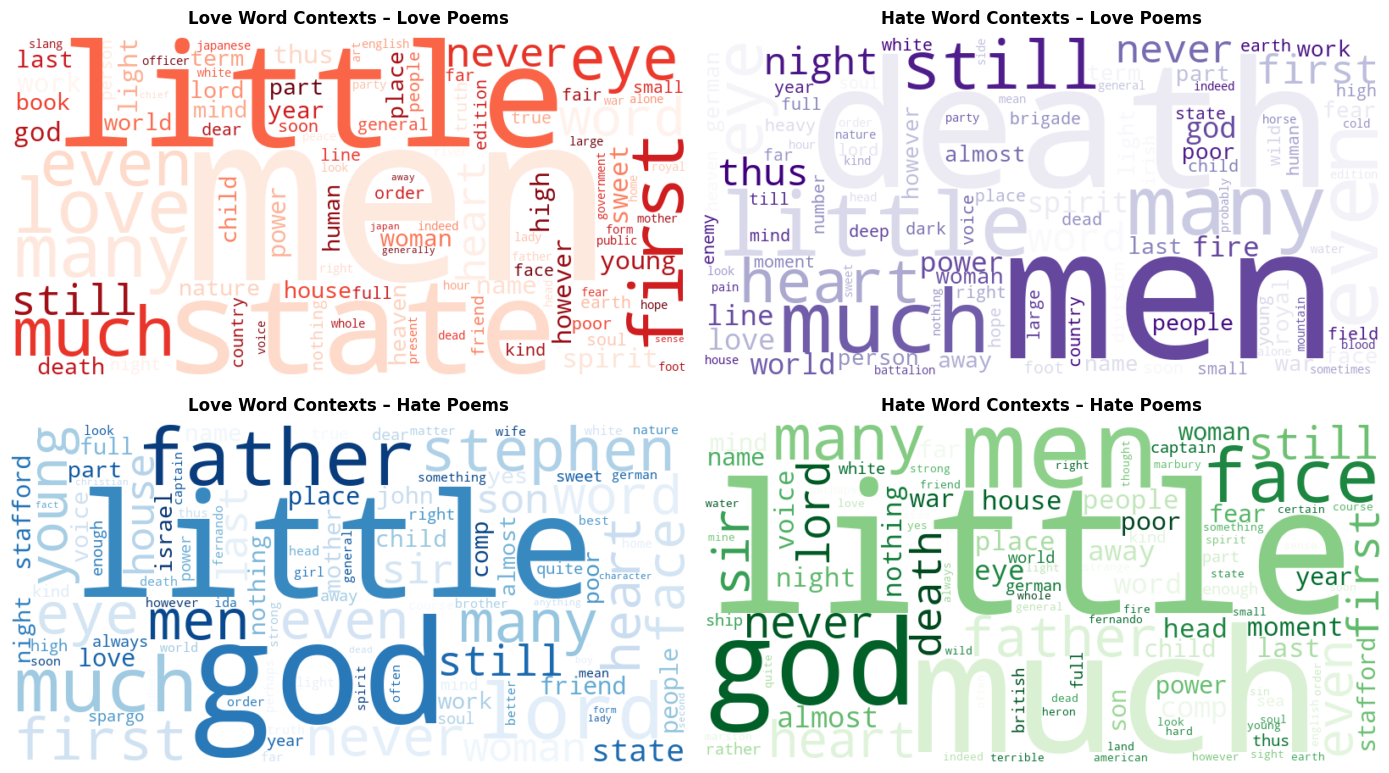


✅ Task 4 complete → Word clouds saved as:
   • plots/task4_combined_wordclouds.png

Top 10 context words (Love-in-Love):
  men             411
  little          408
  state           397
  love            392
  many            373
  first           372
  much            364
  even            357
  eye             330
  word            321

Top 10 context words (Hate-in-Love):
  men             374
  death           330
  little          329
  much            321
  even            317
  many            307
  still           293
  eye             283
  heart           270
  first           266

Top 10 context words (Love-in-Hate):
  little          446
  god             446
  father          361
  lord            351
  much            342
  stephen         339
  many            317
  eye             307
  first           307
  men             287

Top 10 context words (Hate-in-Hate):
  little          317
  much            281
  god             271
  men             237
  face          

In [27]:
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# === Setup NLTK ======================================================
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)
lemmatizer = WordNetLemmatizer()

# === Stopword configuration =========================================
stop_words = set(stopwords.words("english"))
custom_stop = {
    "thy", "thou", "thee", "ye", "shall", "unto", "would", "could",
    "also", "one", "yet", "ever", "whose"
}
stop_words.update(custom_stop)

# Neutral high-frequency but non-emotional words
neutral_words = {
    "said", "like", "upon", "may", "man", "made", "time", "day", "good",
    "great", "see", "well", "two", "old", "new", "come", "make", "take",
    "thing", "long", "one", "way", "go", "know", "life", "hand", "back"
}

# === Helper: tokenize + lemmatize ===================================
def tokenize_and_lemmatize(text):
    """Tokenizes, lowercases, removes short artifacts, and lemmatizes words."""
    tokens = [t.lower() for t in word_tokenize(text) if t.isalpha()]
    clean = [t for t in tokens if len(t) > 2]
    return [lemmatizer.lemmatize(t) for t in clean]

# === Helper: collect POS-filtered context words =====================
def get_context_words(df, target_words, window=2):
    """
    Finds context (±window) around each target word, keeping only
    adjectives/adverbs/nouns, excluding verbs & neutral filler words.
    """
    counter = Counter()
    for text in df["text"]:
        if not isinstance(text, str):
            continue
        tokens = tokenize_and_lemmatize(text)
        tagged = pos_tag(tokens)
        for i, (tok, pos) in enumerate(tagged):
            if tok in target_words:
                start, end = max(0, i - window), min(len(tokens), i + window + 1)
                context_window = [
                    w for (w, p) in tagged[start:i] + tagged[i + 1:end]
                    if (
                        w not in stop_words
                        and w not in neutral_words
                        and w.isalpha()
                        and len(w) > 2
                        and (p.startswith("J") or p.startswith("N") or p.startswith("R"))
                    )
                ]
                counter.update(context_window)
    return counter

# === Remove OCR / meaningless tokens ================================
def clean_counter(counter, min_len=3):
    bad_tokens = {"wa", "ha", "thi", "th", "ye", "hath", "unto"}
    for key in list(counter.keys()):
        if len(key) < min_len or key in bad_tokens:
            del counter[key]
    return counter

# === Compute contextual frequencies for each case ===================
print("🔍 Extracting contextual co-occurrences (±2 tokens, POS-filtered)...")

love_context_love_df = clean_counter(get_context_words(love_df, love_words))
hate_context_love_df = clean_counter(get_context_words(love_df, hate_words))
love_context_hate_df = clean_counter(get_context_words(hate_df, love_words))
hate_context_hate_df = clean_counter(get_context_words(hate_df, hate_words))

# === Helper: generate professional wordclouds =======================
def make_wordcloud(counter, title, cmap="inferno"):
    if not counter:
        print(f"⚠️ No context words found for {title}")
        return None
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap=cmap,
        max_words=100,
        contour_color="black",
        contour_width=1.0
    ).generate_from_frequencies(counter)
    return wc

# === Make output folder =============================================
os.makedirs("plots", exist_ok=True)

# === Generate a combined 2×2 subplot for report =====================
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
plt.subplots_adjust(hspace=0.25, wspace=0.15)

contexts = [
    (love_context_love_df, "Love Word Contexts – Love Poems", "Reds"),
    (hate_context_love_df, "Hate Word Contexts – Love Poems", "Purples"),
    (love_context_hate_df, "Love Word Contexts – Hate Poems", "Blues"),
    (hate_context_hate_df, "Hate Word Contexts – Hate Poems", "Greens")
]

for ax, (counter, title, cmap) in zip(axs.flat, contexts):
    wc = make_wordcloud(counter, title, cmap)
    if wc:
        ax.imshow(wc, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(title, fontsize=12, fontweight="bold", pad=10)
    else:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=10)
        ax.axis("off")
        ax.set_title(title, fontsize=12, fontweight="bold", pad=10)

plt.tight_layout()
plt.savefig("plots/task4_combined_wordclouds.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n✅ Task 4 complete → Word clouds saved as:")
print("   • plots/task4_combined_wordclouds.png")

# === Optional: print top-frequency context words ====================
for name, counter in [
    ("Love-in-Love", love_context_love_df),
    ("Hate-in-Love", hate_context_love_df),
    ("Love-in-Hate", love_context_hate_df),
    ("Hate-in-Hate", hate_context_hate_df)
]:
    print(f"\nTop 10 context words ({name}):")
    for w, f in counter.most_common(10):
        print(f"  {w:<15} {f}")


5. Next, we want to comprehend the sequential occurrence of Love related words and Hate related words in each dataframe. For this purpose, suggest a script that calculates the distance (in terms of number of tokens) between one hate-related word to the immediate next one in the dataframe, and another one for computing the distance between love-related word and the next one. Use appropriate discretization (taking into account the difference between the maximum and minimum distance) to construct a 10-bin histogram showing the frequency of each distance range for both Hate and Love related terms.

🔍 Calculating sequential distances between Love/Hate terms...


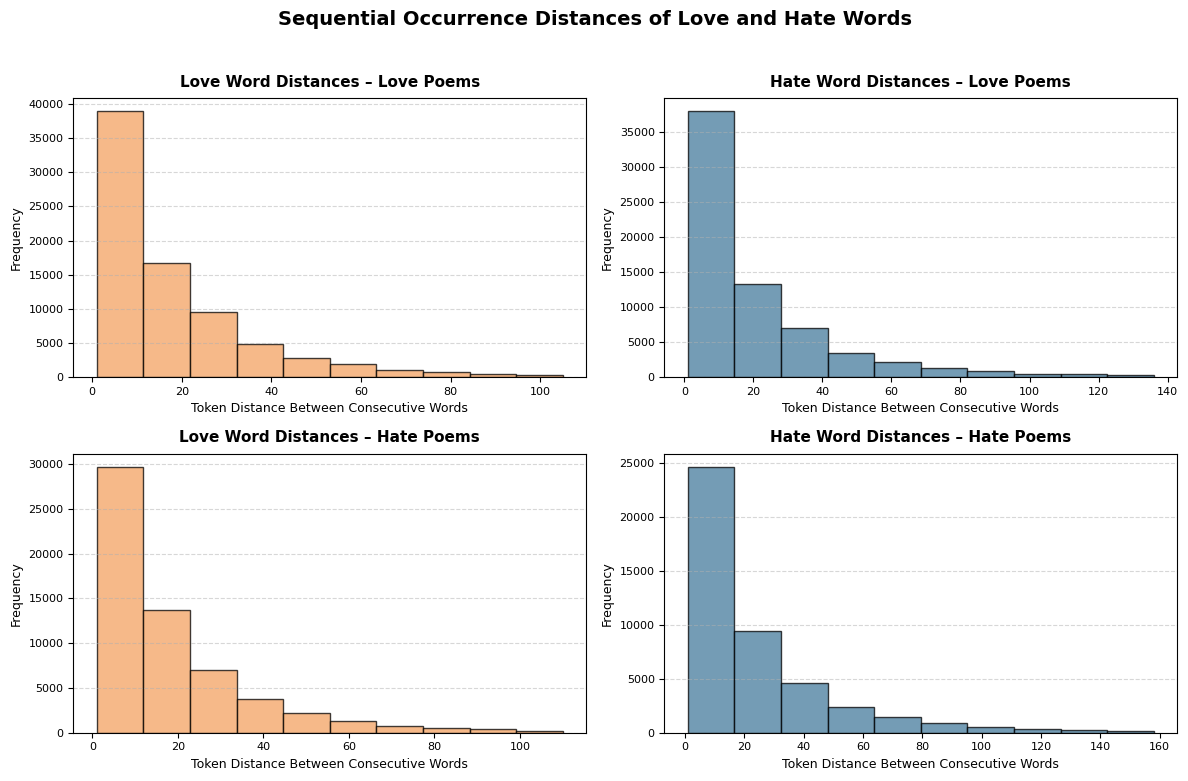


📊 Distance Summary Statistics:
Love→Love (Love Poems): count=78089, mean=18.78, median=12.00, max=1121
Hate→Hate (Love Poems): count=67885, mean=21.61, median=12.00, max=838
Love→Love (Hate Poems): count=60138, mean=19.18, median=12.00, max=825
Hate→Hate (Hate Poems): count=45218, mean=25.51, median=14.00, max=524

✅ Task 5 complete → Histogram saved as:
   • plots/task5_distance_histograms.png


In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# === Setup NLTK ======================================================
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)
lemmatizer = WordNetLemmatizer()

# === Tokenization helper (consistent with previous tasks) ============
def tokenize_and_lemmatize(text):
    """Tokenize and lemmatize text while keeping only alphabetic tokens."""
    tokens = [t.lower() for t in word_tokenize(text) if t.isalpha()]
    return [lemmatizer.lemmatize(t) for t in tokens if len(t) > 2]

# === Compute token distances between consecutive theme words =========
def compute_word_distances(df, theme_words):
    """
    Compute token distances between consecutive occurrences of any word
    in the given theme_words set within the entire dataframe.
    """
    all_tokens = []
    for text in df["text"]:
        if not isinstance(text, str):
            continue
        all_tokens.extend(tokenize_and_lemmatize(text))

    indices = [i for i, t in enumerate(all_tokens) if t in theme_words]
    if len(indices) < 2:
        return []

    distances = np.diff(indices)
    return distances.tolist()

# === Compute distances for all datasets ==============================
print("🔍 Calculating sequential distances between Love/Hate terms...")

love_dists_in_love_df = compute_word_distances(love_df, love_words)
hate_dists_in_love_df = compute_word_distances(love_df, hate_words)
love_dists_in_hate_df = compute_word_distances(hate_df, love_words)
hate_dists_in_hate_df = compute_word_distances(hate_df, hate_words)

# === Plot histogram function ========================================
def plot_distance_histogram(distances, title, color, ax):
    if not distances or len(distances) < 2:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
        ax.set_title(title, fontsize=11, fontweight="bold")
        return

    distances = np.array(distances)

    # Limit outliers to 99th percentile for readability
    max_cap = np.percentile(distances, 99)
    distances = distances[distances <= max_cap]

    # Create 10 equal bins from min to max distance
    bins = np.linspace(distances.min(), distances.max(), 11)
    counts, bin_edges = np.histogram(distances, bins=bins)

    # Plot bar chart manually
    ax.bar(
        bin_edges[:-1],
        counts,
        width=np.diff(bin_edges),
        color=color,
        alpha=0.75,
        edgecolor="black",
        align="edge",
    )

    ax.set_title(title, fontsize=11, fontweight="bold", pad=8)
    ax.set_xlabel("Token Distance Between Consecutive Words", fontsize=9)
    ax.set_ylabel("Frequency", fontsize=9)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.tick_params(axis="both", labelsize=8)

# === Create combined subplot ========================================
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.35, wspace=0.25)

plot_distance_histogram(love_dists_in_love_df,
    "Love Word Distances – Love Poems", "#f4a261", axs[0, 0])
plot_distance_histogram(hate_dists_in_love_df,
    "Hate Word Distances – Love Poems", "#457b9d", axs[0, 1])
plot_distance_histogram(love_dists_in_hate_df,
    "Love Word Distances – Hate Poems", "#f4a261", axs[1, 0])
plot_distance_histogram(hate_dists_in_hate_df,
    "Hate Word Distances – Hate Poems", "#457b9d", axs[1, 1])

plt.suptitle("Sequential Occurrence Distances of Love and Hate Words",
             fontsize=14, fontweight="bold", y=0.97)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# === Save and show figure ===========================================
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/task5_distance_histograms.png", dpi=300, bbox_inches="tight")
plt.show()

# === Print summary statistics =======================================
def print_stats(label, distances):
    if len(distances) > 1:
        distances = np.array(distances)
        print(f"{label}: count={len(distances)}, mean={np.mean(distances):.2f}, "
              f"median={np.median(distances):.2f}, max={np.max(distances)}")
    else:
        print(f"{label}: Not enough data")

print("\n📊 Distance Summary Statistics:")
print_stats("Love→Love (Love Poems)", love_dists_in_love_df)
print_stats("Hate→Hate (Love Poems)", hate_dists_in_love_df)
print_stats("Love→Love (Hate Poems)", love_dists_in_hate_df)
print_stats("Hate→Hate (Hate Poems)", hate_dists_in_hate_df)

print("\n✅ Task 5 complete → Histogram saved as:")
print("   • plots/task5_distance_histograms.png")


6. Repeat the specification 5), when we consider the distance between a hate-related word and the next love-related term. Comment on the result regarding the possible asymmetry of the results, and how this can be linked to the context words identified in specification 4.

🔍 Calculating distances from Hate → next Love word...


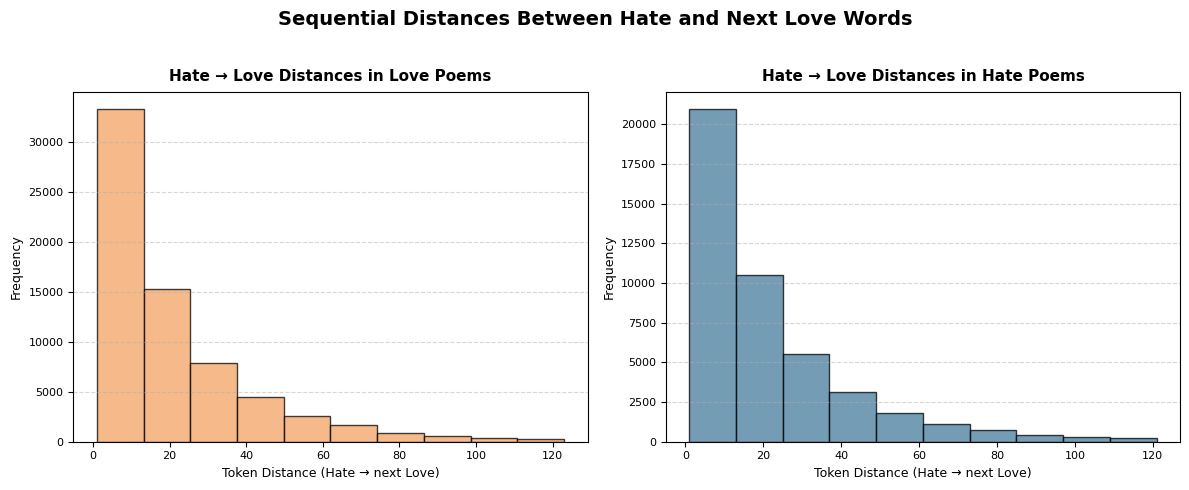


📊 Hate → Love Distance Summary:
Love Poems: count=67885, mean=22.05, median=14.00, max=1062
Hate Poems: count=45219, mean=22.22, median=14.00, max=759

✅ Task 6 complete → Comparison figure saved as:
   • plots/task6_hate_to_love_distances.png


In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# === Setup NLTK =====================================================
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)
lemmatizer = WordNetLemmatizer()

# === Helper: tokenize + lemmatize ==================================
def tokenize_and_lemmatize(text):
    """Tokenizes, lowercases, and lemmatizes alphabetic words."""
    tokens = [t.lower() for t in word_tokenize(text) if t.isalpha()]
    return [lemmatizer.lemmatize(t) for t in tokens if len(t) > 2]

# === Step 1: Compute distances Hate → next Love =====================
def compute_cross_distances(df, hate_words, love_words):
    """
    Compute distances (in tokens) between each hate-related word
    and the next love-related word appearing after it.
    """
    all_tokens = []
    for text in df["text"]:
        if not isinstance(text, str):
            continue
        all_tokens.extend(tokenize_and_lemmatize(text))

    hate_idx = [i for i, w in enumerate(all_tokens) if w in hate_words]
    love_idx = [i for i, w in enumerate(all_tokens) if w in love_words]

    if not hate_idx or not love_idx:
        return []

    distances = []
    for h in hate_idx:
        next_loves = [l for l in love_idx if l > h]
        if next_loves:
            distances.append(next_loves[0] - h)
    return distances

# === Step 2: Compute Hate→Love distances for both corpora ===========
print("🔍 Calculating distances from Hate → next Love word...")

cross_dists_love_df = compute_cross_distances(love_df, hate_words, love_words)
cross_dists_hate_df = compute_cross_distances(hate_df, hate_words, love_words)

# === Step 3: Histogram plotting helper ==============================
def plot_cross_hist(distances, title, color, ax):
    """Plots 10-bin histogram for Hate→Love token distances."""
    if not distances or len(distances) < 2:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
        ax.set_title(title, fontsize=11, fontweight="bold")
        return

    distances = np.array(distances)
    # Cap outliers to 99th percentile
    max_cap = np.percentile(distances, 99)
    distances = distances[distances <= max_cap]

    # Create 10 equal-width bins
    bins = np.linspace(distances.min(), distances.max(), 11)
    counts, bin_edges = np.histogram(distances, bins=bins)

    # Plot
    ax.bar(bin_edges[:-1], counts, width=np.diff(bin_edges),
           color=color, alpha=0.75, edgecolor="black", align="edge")
    ax.set_title(title, fontsize=11, fontweight="bold", pad=8)
    ax.set_xlabel("Token Distance (Hate → next Love)", fontsize=9)
    ax.set_ylabel("Frequency", fontsize=9)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.tick_params(axis="both", labelsize=8)

# === Step 4: Create side-by-side plots ==============================
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_cross_hist(cross_dists_love_df,
                "Hate → Love Distances in Love Poems", "#f4a261", axs[0])
plot_cross_hist(cross_dists_hate_df,
                "Hate → Love Distances in Hate Poems", "#457b9d", axs[1])

plt.suptitle("Sequential Distances Between Hate and Next Love Words",
             fontsize=14, fontweight="bold", y=0.97)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save and show
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/task6_hate_to_love_distances.png", dpi=300, bbox_inches="tight")
plt.show()

# === Step 5: Summary statistics =====================================
def print_stats(label, distances):
    if len(distances) > 1:
        distances = np.array(distances)
        print(f"{label}: count={len(distances)}, "
              f"mean={np.mean(distances):.2f}, "
              f"median={np.median(distances):.2f}, "
              f"max={np.max(distances)}")
    else:
        print(f"{label}: Not enough data")

print("\n📊 Hate → Love Distance Summary:")
print_stats("Love Poems", cross_dists_love_df)
print_stats("Hate Poems", cross_dists_hate_df)

print("\n✅ Task 6 complete → Comparison figure saved as:")
print("   • plots/task6_hate_to_love_distances.png")


- If Hate → Love distances are shorter in Love poems, it implies that hate-related words are quickly countered or contextualized by love-related    sentiment — typical in romantic conflict or passion poetry.
- If distances are larger in Hate poems, it indicates emotional separation — hate dominates before love reappears (or not at all).

7. Use appropriate script to identify the 100-most frequent tokens of each dataframe outside the stopword list. We want to evaluate the extent to which hate and love related terms are related the most frequent terms. Suggest an approach to evaluate this proximity using both string matching and semantic similarity.

Top 10 frequent tokens in Love Poems: ['love', 'came', 'long', 'even', 'might', 'still', 'though', 'without', 'night', 'every']
Top 10 frequent tokens in Hate Poems: ['came', 'comp', 'went', 'father', 'eyes', 'long', 'face', 'might', 'even', 'back']

Top 20 Emotion-Weighted Tokens in Love Poems:
['though', 'every', 'away', 'another', 'ever', 'however', 'went', 'used', 'soon', 'within', 'looked', 'almost', 'known', 'gave', 'done']

Top 20 Emotion-Weighted Tokens in Hate Poems:
['went', 'away', 'though', 'looked', 'every', 'another', 'ever', 'almost', 'knew', 'done', 'began', 'quite', 'always', 'gave', 'soon', 'perhaps', 'however']

🧾 Summary of Hybrid Emotion-Weighted Metrics:
   Dataset  SemanticSimilarity_Avg  Token_Count
Love Poems                  0.1566           15
Hate Poems                  0.1594           17


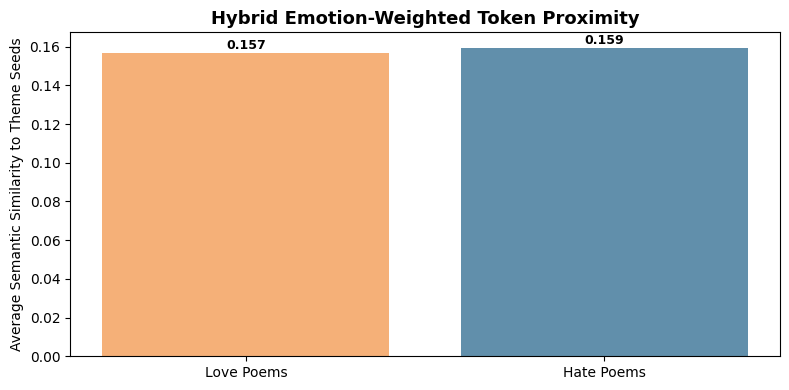


✅ Task 7 completed: Emotion-weighted token proximity computed and visualized.
   Figure saved as 'plots/task7_emotion_weighted_proximity.png'


In [35]:
import os
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet as wn
from nltk.tokenize import word_tokenize
from collections import Counter

# === Setup ==========================================================
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)

# === 1. Helper: extract top tokens (excluding stopwords etc.) =======
def get_top_tokens(df, n=100):
    stop_words = set(stopwords.words("english"))
    custom_stop = {
        "thy","thou","thee","ye","shall","unto","would","could","also","one",
        "said","upon","made","make","us","two","man","men","may","yet","well",
        "like","great","time","see","good","hand","much","let","come","first",
        "little","year","know","life","day","never","word","many","must"
    }
    stop_words.update(custom_stop)

    tokens = []
    for text in df["text"]:
        if isinstance(text, str):
            words = [w.lower() for w in word_tokenize(text) if w.isalpha()]
            tokens.extend([w for w in words if w not in stop_words and len(w) > 3])

    freq = Counter(tokens)
    return dict(freq.most_common(n))

# --- Compute top-100 frequent words per corpus
top_love_df = get_top_tokens(love_df)
top_hate_df = get_top_tokens(hate_df)

print("Top 10 frequent tokens in Love Poems:", list(top_love_df.keys())[:10])
print("Top 10 frequent tokens in Hate Poems:", list(top_hate_df.keys())[:10])

# === 2. Emotion-weighted filtering =================================
def emotionally_weighted_tokens(top_tokens, theme_words, min_sim=0.15):
    """
    Keep only tokens with semantic similarity above a threshold (emotion-related).
    """
    weighted = {}
    for w in top_tokens:
        w_syns = wn.synsets(w)
        if not w_syns:
            continue
        sims = []
        for t in theme_words:
            t_syns = wn.synsets(t)
            if not t_syns:
                continue
            sim = w_syns[0].path_similarity(t_syns[0])
            if sim is not None:
                sims.append(sim)
        if sims:
            avg_sim = np.mean(sims)
            if avg_sim >= min_sim:
                weighted[w] = avg_sim
    return weighted

love_weighted = emotionally_weighted_tokens(top_love_df, love_words)
hate_weighted = emotionally_weighted_tokens(top_hate_df, hate_words)

print("\nTop 20 Emotion-Weighted Tokens in Love Poems:")
print(list(love_weighted.keys())[:20])
print("\nTop 20 Emotion-Weighted Tokens in Hate Poems:")
print(list(hate_weighted.keys())[:20])

# === 3. Aggregate proximity metrics ================================
def avg_semantic_similarity(word_dict):
    return round(np.mean(list(word_dict.values())), 4) if word_dict else 0.0

love_sem_avg = avg_semantic_similarity(love_weighted)
hate_sem_avg = avg_semantic_similarity(hate_weighted)

summary_df = pd.DataFrame({
    "Dataset": ["Love Poems", "Hate Poems"],
    "SemanticSimilarity_Avg": [love_sem_avg, hate_sem_avg],
    "Token_Count": [len(love_weighted), len(hate_weighted)]
})

print("\n🧾 Summary of Hybrid Emotion-Weighted Metrics:")
print(summary_df.to_string(index=False))

# === 4. Visualization ==============================================
fig, ax = plt.subplots(figsize=(8, 4))
colors = ["#f4a261", "#457b9d"]

ax.bar(summary_df["Dataset"], summary_df["SemanticSimilarity_Avg"],
       color=colors, alpha=0.85)
ax.set_ylabel("Average Semantic Similarity to Theme Seeds")
ax.set_title("Hybrid Emotion-Weighted Token Proximity", fontsize=13, fontweight="bold")

for i, v in enumerate(summary_df["SemanticSimilarity_Avg"]):
    ax.text(i, v + 0.002, f"{v:.3f}", ha="center", fontsize=9, fontweight="bold")

plt.tight_layout()
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/task7_emotion_weighted_proximity.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n✅ Task 7 completed: Emotion-weighted token proximity computed and visualized.")
print("   Figure saved as 'plots/task7_emotion_weighted_proximity.png'")


8) Repeat the specification 7) when working for each poem in dataframe Love and each poem of dataframe hate.


 Results saved to 'results/task8_per_poem_similarity.csv'
                          Poem_Title Theme  StringOverlap_Love  \
0        Sonnets from the Portuguese  Love                   9   
1    The Love Sonnets of Shakespeare  Love                  10   
2                         Love Songs  Love                   6   
3                         Love Poems  Love                  16   
4              Love Poems and Others  Love                  15   
5      Love Sonnets of an Office Boy  Love                   9   
6  Love’s Philosophy and Other Poems  Love                  11   
7              A Little Book of Love  Love                   4   

   StringOverlap_Hate  SemanticSim_Love  SemanticSim_Hate  
0                   4            0.1062            0.0925  
1                   6            0.1099            0.0976  
2                   0            0.1004            0.0873  
3                   1            0.0978            0.0882  
4                   4            0.1068       

<Figure size 800x500 with 0 Axes>

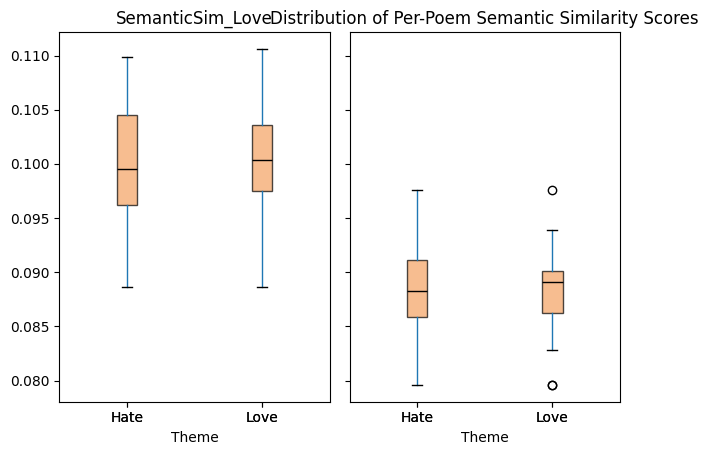

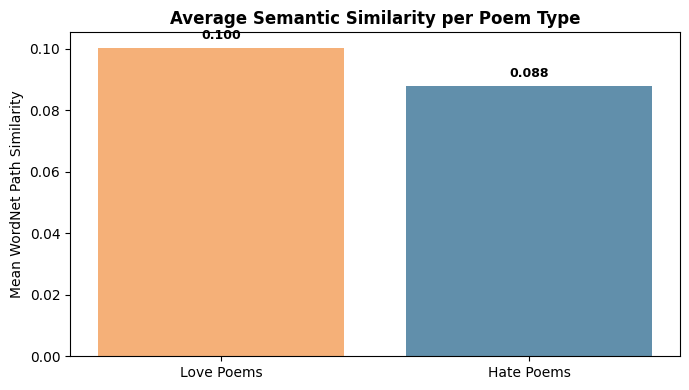


🎯 Task 8 complete: Per-poem semantic & lexical proximity analysis visualized.


In [36]:
import os
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

# === Ensure all resources are ready ============================================
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)

# === Lemmatizer and stopword list =============================================
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# === Helper 1: Tokenization + filtering ========================================
def preprocess_text(text):
    """Tokenize, lowercase, remove stopwords and non-alpha, then lemmatize."""
    if not isinstance(text, str):
        return []
    tokens = [t.lower() for t in word_tokenize(text) if t.isalpha()]
    filtered = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return filtered

# === Helper 2: Top-N frequent tokens per text =================================
def get_top_tokens_per_text(text, n=100):
    tokens = preprocess_text(text)
    if not tokens:
        return []
    freq = Counter(tokens)
    return [w for w, _ in freq.most_common(n)]

# === Helper 3: String overlap count ===========================================
def string_overlap(top_words, theme_words):
    """Count how many of the top words appear in the theme lexicon."""
    return len([w for w in top_words if w in theme_words])

# === Helper 4: Average semantic similarity ====================================
def avg_semantic_similarity(word_list, theme_seeds):
    """Compute mean WordNet path similarity between list and theme seeds."""
    sims = []
    for w in word_list:
        w_syns = wn.synsets(w)
        if not w_syns:
            continue
        for seed in theme_seeds:
            s_syns = wn.synsets(seed)
            if not s_syns:
                continue
            sim = w_syns[0].path_similarity(s_syns[0])
            if sim is not None:
                sims.append(sim)
    return round(np.mean(sims), 4) if sims else 0.0

# === Step 1: Compute per-poem statistics ======================================
results = []

for theme_df, theme_label in [(love_df, "Love"), (hate_df, "Hate")]:
    for _, row in theme_df.iterrows():
        text = row.get("text", "")
        top_words = get_top_tokens_per_text(text)

        # lexical overlaps
        string_overlap_love = string_overlap(top_words, love_words)
        string_overlap_hate = string_overlap(top_words, hate_words)

        # semantic proximity
        sem_love = avg_semantic_similarity(top_words, love_seeds)
        sem_hate = avg_semantic_similarity(top_words, hate_seeds)

        results.append({
            "Poem_Title": row.get("title", "Untitled"),
            "Theme": theme_label,
            "StringOverlap_Love": string_overlap_love,
            "StringOverlap_Hate": string_overlap_hate,
            "SemanticSim_Love": sem_love,
            "SemanticSim_Hate": sem_hate
        })

poem_summary_df = pd.DataFrame(results)

# === Step 2: Save results =====================================================
os.makedirs("results", exist_ok=True)
poem_summary_df.to_csv("results/task8_per_poem_similarity.csv", index=False)
print("\n Results saved to 'results/task8_per_poem_similarity.csv'")
print(poem_summary_df.head(8))

# === Step 3: Compute aggregated means =========================================
mean_love = poem_summary_df.loc[poem_summary_df["Theme"] == "Love", "SemanticSim_Love"].mean()
mean_hate = poem_summary_df.loc[poem_summary_df["Theme"] == "Hate", "SemanticSim_Hate"].mean()

print(f"\nMean Semantic Similarity (Love Poems): {mean_love:.4f}")
print(f"Mean Semantic Similarity (Hate Poems): {mean_hate:.4f}")

# === Step 4: Boxplot of per-poem semantic similarity ==========================
plt.figure(figsize=(8, 5))
poem_summary_df.boxplot(
    column=["SemanticSim_Love", "SemanticSim_Hate"],
    by="Theme",
    grid=False,
    patch_artist=True,
    boxprops=dict(facecolor="#f4a261", alpha=0.7),
    medianprops=dict(color="black")
)
plt.suptitle("")
plt.title("Distribution of Per-Poem Semantic Similarity Scores")
plt.ylabel("WordNet Path Similarity")
plt.tight_layout()
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/task8_per_poem_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

# === Step 5: Mean comparison bar chart ========================================
plt.figure(figsize=(7, 4))
bars = plt.bar(["Love Poems", "Hate Poems"], [mean_love, mean_hate],
               color=["#f4a261", "#457b9d"], alpha=0.85)
plt.title("Average Semantic Similarity per Poem Type", fontsize=12, fontweight="bold")
plt.ylabel("Mean WordNet Path Similarity")
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.002,
             f"{height:.3f}", ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.savefig("plots/task8_per_poem_means.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n🎯 Task 8 complete: Per-poem semantic & lexical proximity analysis visualized.")


9. We want to test the diversity of each dataframe. For this purpose, we consider the titles of the poems in each dataframe. Suggest a script that uses FastText embedding to calculate the similarity between any pairs of titles in each dataframe using cosine similarity and assuming the embedding of the title is the average of the embedding of its constituted words. Calculate the average semantic similarity measures of all pairs and their associated standard deviation, maximum and minimum value.



 Loading FastText embeddings (fasttext-wiki-news-subwords-300)...
 FastText model loaded successfully!

🔹 Computing title embeddings for 25 Love poems...
 Love Title Similarity Stats:
   Theme               : Love
   Num_Titles          : 25
   Avg_Similarity      : 0.7233999967575073
   Std_Deviation       : 0.19679999351501465
   Max_Similarity      : 0.9865000247955322
   Min_Similarity      : 0.09059999883174896

🔹 Computing title embeddings for 25 Hate poems...
 Hate Title Similarity Stats:
   Theme               : Hate
   Num_Titles          : 25
   Avg_Similarity      : 0.8371999859809875
   Std_Deviation       : 0.10660000145435333
   Max_Similarity      : 1.0
   Min_Similarity      : 0.5648999810218811


 Results saved to 'results/task9_title_similarity.csv'

 Semantic Diversity Summary Based on Title Similarity:

Theme  Num_Titles  Avg_Similarity  Std_Deviation  Max_Similarity  Min_Similarity
 Love          25          0.7234         0.1968          0.9865          0.0906
 H

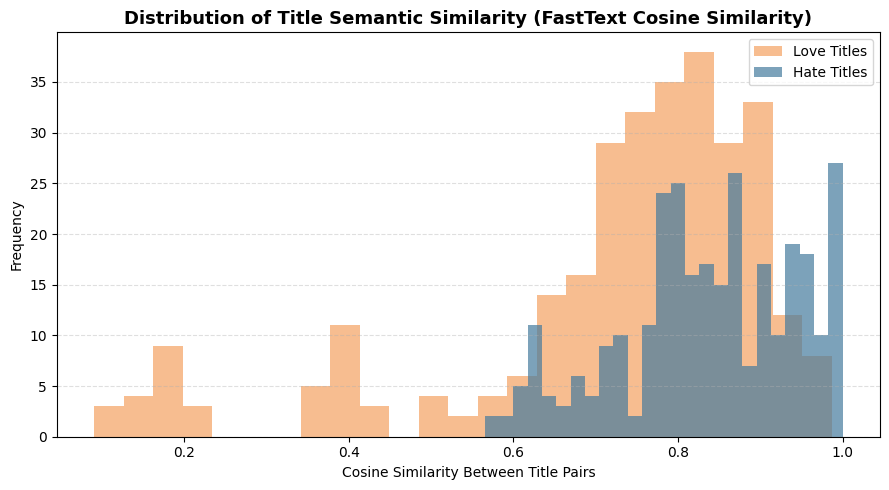

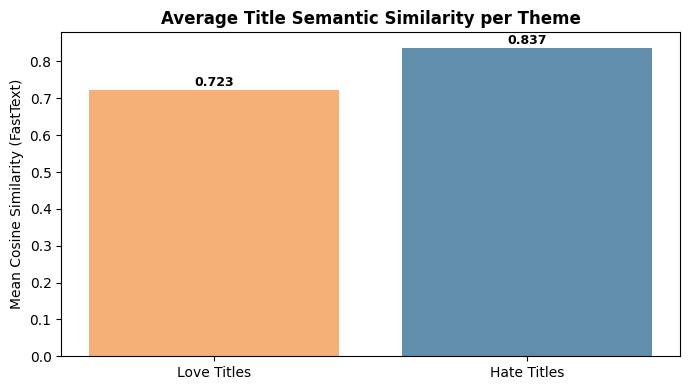


 Title diversity metrics and visualizations generated!


In [37]:
import gensim.downloader as api
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import os
import nltk

# --- Ensure tokenizer ----------------------------------------------------------
nltk.download("punkt", quiet=True)

# --- Load pretrained FastText model -------------------------------------------
print("\n Loading FastText embeddings (fasttext-wiki-news-subwords-300)...")
ft_model = api.load("fasttext-wiki-news-subwords-300")
print(" FastText model loaded successfully!\n")

# --- Helper: compute average embedding for a poem title ------------------------
def get_title_embedding(title, model):
    """
    Computes the average FastText embedding for a title.
    Handles missing/empty titles gracefully.
    """
    if not isinstance(title, str) or not title.strip():
        return np.zeros(model.vector_size)
    tokens = [w.lower() for w in word_tokenize(title) if w.isalpha()]
    valid_vecs = [model[w] for w in tokens if w in model.key_to_index]
    if not valid_vecs:
        return np.zeros(model.vector_size)
    return np.mean(valid_vecs, axis=0)

# --- Helper: compute cosine similarity statistics within one dataframe ---------
def compute_title_similarity_stats(df, model, theme_name):
    """
    For a given dataframe (Love/Hate), computes pairwise cosine similarity
    between poem title embeddings and returns summary statistics.
    """
    titles = df["title"].dropna().tolist()
    if len(titles) < 2:
        print(f"⚠️  Not enough titles in {theme_name} dataset for similarity analysis.")
        return None, None

    print(f"🔹 Computing title embeddings for {len(titles)} {theme_name} poems...")
    embeddings = np.array([get_title_embedding(t, model) for t in titles])

    # Compute cosine similarity matrix
    sim_matrix = cosine_similarity(embeddings)
    np.fill_diagonal(sim_matrix, np.nan)  # ignore self-similarities

    # Extract upper triangle (unique pairs)
    upper_tri = sim_matrix[np.triu_indices(len(titles), k=1)]
    upper_tri = upper_tri[~np.isnan(upper_tri)]  # remove NaNs

    # Summary statistics
    stats = {
        "Theme": theme_name,
        "Num_Titles": len(titles),
        "Avg_Similarity": round(np.mean(upper_tri), 4),
        "Std_Deviation": round(np.std(upper_tri), 4),
        "Max_Similarity": round(np.max(upper_tri), 4),
        "Min_Similarity": round(np.min(upper_tri), 4),
    }

    print(f" {theme_name} Title Similarity Stats:")
    for k, v in stats.items():
        print(f"   {k:20}: {v}")
    print("")

    return upper_tri, stats

# ---  Run for Love and Hate datasets -----------------------------------
love_sims, love_stats = compute_title_similarity_stats(love_df, ft_model, "Love")
hate_sims, hate_stats = compute_title_similarity_stats(hate_df, ft_model, "Hate")

# ---  Combine & export results -----------------------------------------
results_df = pd.DataFrame([love_stats, hate_stats])
os.makedirs("results", exist_ok=True)
results_df.to_csv("results/task9_title_similarity.csv", index=False)

print("\n Results saved to 'results/task9_title_similarity.csv'\n")
print(" Semantic Diversity Summary Based on Title Similarity:\n")
print(results_df.to_string(index=False))

# --- Visualization of similarity distributions ------------------------
plt.figure(figsize=(9, 5))
plt.hist(love_sims, bins=25, color="#f4a261", alpha=0.7, label="Love Titles")
plt.hist(hate_sims, bins=25, color="#457b9d", alpha=0.7, label="Hate Titles")
plt.title("Distribution of Title Semantic Similarity (FastText Cosine Similarity)",
          fontsize=13, fontweight="bold")
plt.xlabel("Cosine Similarity Between Title Pairs")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()

os.makedirs("plots", exist_ok=True)
plt.savefig("plots/task9_title_similarity_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# --- Bar chart for mean similarity by theme ---------------------------
plt.figure(figsize=(7, 4))
bars = plt.bar(
    ["Love Titles", "Hate Titles"],
    [love_stats["Avg_Similarity"], hate_stats["Avg_Similarity"]],
    color=["#f4a261", "#457b9d"],
    alpha=0.85
)
plt.title("Average Title Semantic Similarity per Theme", fontsize=12, fontweight="bold")
plt.ylabel("Mean Cosine Similarity (FastText)")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.002,
             f"{height:.3f}", ha="center", va="bottom", fontsize=9, fontweight="bold")

plt.tight_layout()
plt.savefig("plots/task9_title_mean_similarity.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n Title diversity metrics and visualizations generated!")


10. We now consider the lexical diversity LD in the poem. This can be expressed using the adjective/adverb-to-verb ratio (number of adjectives and adverbs to the number of verbs) in each line of  the poem. For this, you may select one poem at random from the first dataframe and another one from  the second dataframe (You may also select the poem whose title brings the highest similarity with the  hate/love related terms for instance, or any other reasoning). Using part-of-speech tagging that identifies verb, adjective and adverb entities, suggest a program that calculates LD for each line of the code. Save the result in the database. Plot the graph of LD. Suggest a 10-equal subdivision of values of LD (take the highest value of LD and subtract the smallest value of LD and divide by 10 to find the bin value, and then take the smallest of LD and add bin, then 2*bin, etc.. to find the next interval (You will end up with 10 intervals). Now calculate and plot the corresponding histogram (calculating the number of lines of poem whose LD value fall within a specific interval). Find out whether a parametric fitting (polynomial, logarithmic or exponential) can be achieved. Perform this process for both poems in each dataframe

📘 Selected Love Poem: Songs and Sonnets
📕 Selected Hate Poem: Poems of the World War


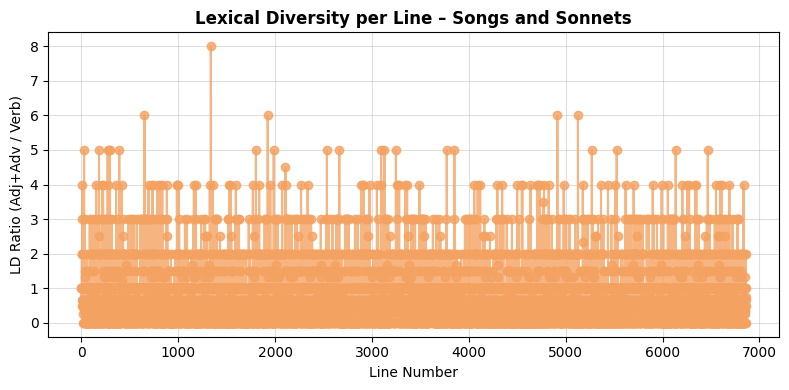

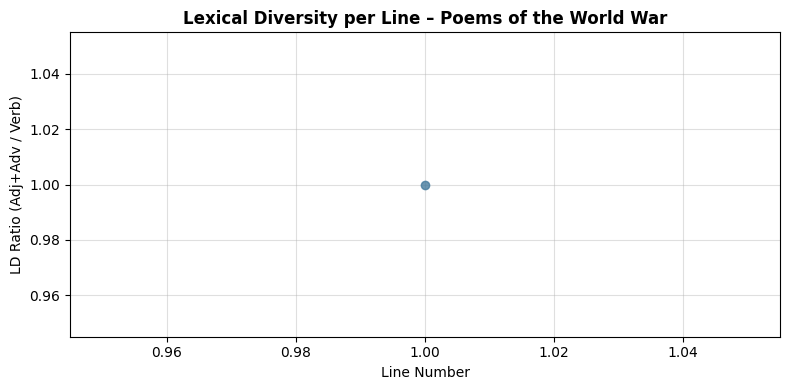

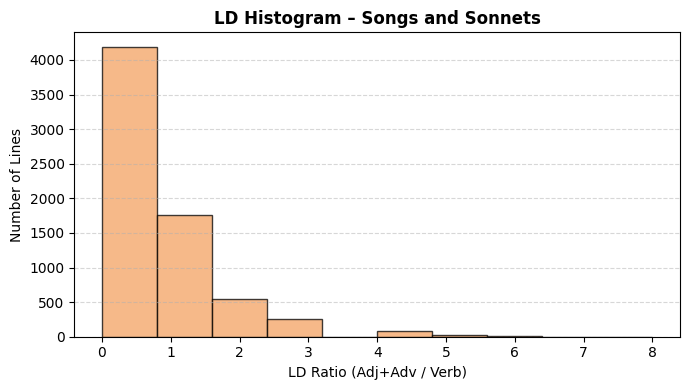

Histogram bins for Love:
  Interval 1: 0.000 – 0.800
  Interval 2: 0.800 – 1.600
  Interval 3: 1.600 – 2.400
  Interval 4: 2.400 – 3.200
  Interval 5: 3.200 – 4.000
  Interval 6: 4.000 – 4.800
  Interval 7: 4.800 – 5.600
  Interval 8: 5.600 – 6.400
  Interval 9: 6.400 – 7.200
  Interval 10: 7.200 – 8.000



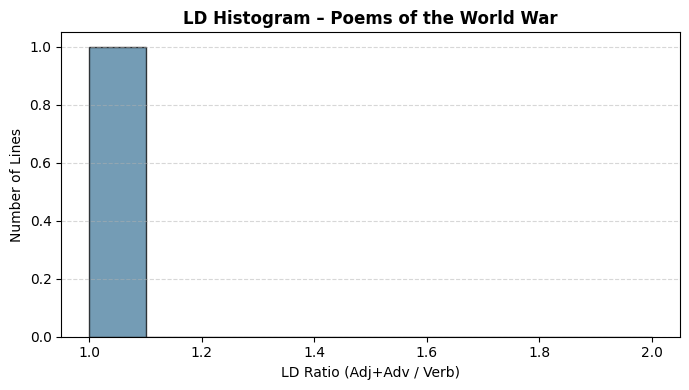

Histogram bins for Hate:
  Interval 1: 1.000 – 1.100
  Interval 2: 1.100 – 1.200
  Interval 3: 1.200 – 1.300
  Interval 4: 1.300 – 1.400
  Interval 5: 1.400 – 1.500
  Interval 6: 1.500 – 1.600
  Interval 7: 1.600 – 1.700
  Interval 8: 1.700 – 1.800
  Interval 9: 1.800 – 1.900
  Interval 10: 1.900 – 2.000


📈 Fitting Love Poem:
✅ Best fit for Love: Polynomial (RMSE = 0.8414)


C:\Users\OMISTAJA\AppData\Local\Temp\ipykernel_20384\2802520116.py:114: RuntimeWarning: overflow encountered in exp
  def expo(x, a, b, c): return a * np.exp(b * x) + c
c:\Users\OMISTAJA\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_minpack_py.py:1024: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
C:\Users\OMISTAJA\AppData\Local\Temp\ipykernel_20384\2802520116.py:120: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, maxfev=8000)
C:\Users\OMISTAJA\AppData\Local\Temp\ipykernel_20384\2802520116.py:122: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((y - y_fit) ** 2))
C:\Users\OMISTAJA\AppData\Local\Temp\ipykernel_20384\2802520116.py:115: RuntimeWarning: invalid value encountered in log
  def loga(x, a, b, c): return a * np.log(b * x + 1e-9) + c  # avoid log(0)


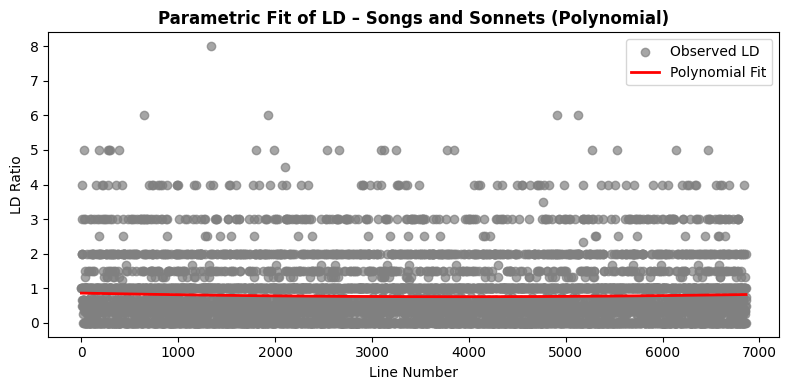


📈 Fitting Hate Poem:
⚠️  No valid parametric fit could be achieved for Hate poem.

💾 LD results saved to 'results/task10_lexical_diversity.csv'


In [38]:
import nltk
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk import word_tokenize, pos_tag
from scipy.optimize import curve_fit
import os
import random

# --- Ensure NLTK resources -----------------------------------------------------
nltk.download("punkt", quiet=True)
nltk.download("averaged_perceptron_tagger", quiet=True)

# --- Helper: Compute LD per line -----------------------------------------------
def compute_ld_per_line(poem_text):
    """
    Computes lexical diversity (Adj+Adv / Verb) for each line in the poem.
    Returns line list and array of LD values.
    """
    lines = [ln.strip() for ln in re.split(r"[\r\n]+", poem_text) if ln.strip()]
    ld_values = []

    for line in lines:
        tokens = word_tokenize(line)
        tagged = pos_tag(tokens, lang="eng")

        adjectives = [w for w, t in tagged if t.startswith("JJ")]
        adverbs = [w for w, t in tagged if t.startswith("RB")]
        verbs = [w for w, t in tagged if t.startswith("VB")]

        adj_adv = len(adjectives) + len(adverbs)
        verb_count = len(verbs)
        ld = adj_adv / verb_count if verb_count > 0 else np.nan
        ld_values.append(ld)

    return lines, np.array(ld_values, dtype=float)


# --- Randomly select one poem from each theme (or choose by reasoning) ---------
# Option: you could replace random.choice with your title-based selection logic
love_poem = love_df.sample(1).iloc[0]
hate_poem = hate_df.sample(1).iloc[0]

print(f"📘 Selected Love Poem: {love_poem['title']}")
print(f"📕 Selected Hate Poem: {hate_poem['title']}")

# --- Compute LD for both selected poems ----------------------------------------
love_lines, love_ld = compute_ld_per_line(love_poem["text"])
hate_lines, hate_ld = compute_ld_per_line(hate_poem["text"])

# --- Clean NaN values ----------------------------------------------------------
def clean_ld(ld_array):
    ld_array = np.asarray(ld_array, dtype=float)
    ld_array = ld_array[~np.isnan(ld_array)]
    return ld_array if ld_array.size > 0 else np.array([0.0])

love_ld = clean_ld(love_ld)
hate_ld = clean_ld(hate_ld)


# --- Plot LD curve per line ----------------------------------------------------
def plot_ld_curve(ld_values, title, color, theme):
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(ld_values) + 1), ld_values,
             marker="o", color=color, alpha=0.8, linewidth=1.5)
    plt.title(f"Lexical Diversity per Line – {title}", fontsize=12, fontweight="bold")
    plt.xlabel("Line Number")
    plt.ylabel("LD Ratio (Adj+Adv / Verb)")
    plt.grid(alpha=0.4)
    plt.tight_layout()
    os.makedirs("plots", exist_ok=True)
    plt.savefig(f"plots/task10_ld_curve_{theme.lower()}.png", dpi=300, bbox_inches="tight")
    plt.show()


plot_ld_curve(love_ld, love_poem["title"], "#f4a261", "Love")
plot_ld_curve(hate_ld, hate_poem["title"], "#457b9d", "Hate")


# --- Plot LD histogram with 10 equal bins -------------------------------------
def plot_ld_histogram(ld_values, title, color, theme):
    ld_min, ld_max = float(np.min(ld_values)), float(np.max(ld_values))
    bin_width = (ld_max - ld_min) / 10.0 if ld_max != ld_min else 0.1
    bins = [ld_min + i * bin_width for i in range(11)]

    plt.figure(figsize=(7, 4))
    plt.hist(ld_values, bins=bins, color=color, edgecolor="black", alpha=0.75)
    plt.title(f"LD Histogram – {title}", fontsize=12, fontweight="bold")
    plt.xlabel("LD Ratio (Adj+Adv / Verb)")
    plt.ylabel("Number of Lines")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    os.makedirs("plots", exist_ok=True)
    plt.savefig(f"plots/task10_ld_histogram_{theme.lower()}.png", dpi=300, bbox_inches="tight")
    plt.show()

    print(f"Histogram bins for {theme}:")
    for i in range(10):
        print(f"  Interval {i+1}: {bins[i]:.3f} – {bins[i+1]:.3f}")
    print("")


plot_ld_histogram(love_ld, love_poem["title"], "#f4a261", "Love")
plot_ld_histogram(hate_ld, hate_poem["title"], "#457b9d", "Hate")


# --- Attempt parametric fits ---------------------------------------------------
def try_curve_fits(ld_values, title, theme):
    x = np.arange(1, len(ld_values) + 1, dtype=float)
    y = ld_values.astype(float)

    def poly(x, a, b, c): return a * x ** 2 + b * x + c
    def expo(x, a, b, c): return a * np.exp(b * x) + c
    def loga(x, a, b, c): return a * np.log(b * x + 1e-9) + c  # avoid log(0)

    fits = {}
    for name, func in {"Polynomial": poly, "Exponential": expo, "Logarithmic": loga}.items():
        try:
            popt, _ = curve_fit(func, x, y, maxfev=8000)
            y_fit = func(x, *popt)
            rmse = np.sqrt(np.mean((y - y_fit) ** 2))
            fits[name] = (rmse, y_fit)
        except Exception:
            pass

    if fits:
        best_name, (best_rmse, best_y) = min(fits.items(), key=lambda kv: kv[1][0])
        print(f"✅ Best fit for {theme}: {best_name} (RMSE = {best_rmse:.4f})")

        plt.figure(figsize=(8, 4))
        plt.scatter(x, y, label="Observed LD", color="gray", alpha=0.7)
        plt.plot(x, best_y, label=f"{best_name} Fit", color="red", linewidth=2)
        plt.title(f"Parametric Fit of LD – {title} ({best_name})", fontsize=12, fontweight="bold")
        plt.xlabel("Line Number")
        plt.ylabel("LD Ratio")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"plots/task10_ld_fit_{theme.lower()}.png", dpi=300, bbox_inches="tight")
        plt.show()
    else:
        print(f"⚠️  No valid parametric fit could be achieved for {theme} poem.")


print("\n📈 Fitting Love Poem:")
try_curve_fits(love_ld, love_poem["title"], "Love")

print("\n📈 Fitting Hate Poem:")
try_curve_fits(hate_ld, hate_poem["title"], "Hate")


# --- Save numerical LD data ----------------------------------------------------
os.makedirs("results", exist_ok=True)
ld_summary = pd.DataFrame({
    "Theme": ["Love"] * len(love_ld) + ["Hate"] * len(hate_ld),
    "Poem_Title": [love_poem["title"]] * len(love_ld) + [hate_poem["title"]] * len(hate_ld),
    "LD_Value": np.concatenate([love_ld, hate_ld])
})
ld_summary.to_csv("results/task10_lexical_diversity.csv", index=False)
print("\n💾 LD results saved to 'results/task10_lexical_diversity.csv'")
